In [26]:
!nvidia-smi
import seaborn as sns
sns.set()

Thu Jan 30 18:38:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:1A:00.0 Off |                  N/A |
| 29%   22C    P8     6W / 250W |     12MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:1B:00.0 Off |                  N/A |
| 31%   48C    P2    86W / 250W |  10671MiB / 11019MiB |     37%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [27]:
# from tensorflow.keras.models import load_model
from scipy import stats
# import tensorflow as tf
import math
import itertools
import operator
# from tensorflow.python.keras import backend as k
from tqdm import tqdm, tqdm_notebook, notebook
import numpy as np
# from tensorflow.keras import layers
import os
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
import random
from random import choice
import re

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle

from sklearn.preprocessing import LabelEncoder
from bio import AlignIO
# from Bio.Align import MultipleSeqAlignment
# from Bio.SeqRecord import SeqRecord
# from Bio import SeqIO
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import sklearn
import numpy as np
import re
import pickle
import itertools
import random
import string
from joblib import dump, load

%precision 2

# os.environ["CUDA_VISIBLE_DEVICES"]="7"
context_length = 15
val_loss_hist = []

# K.clear_session()
# keras.backend.clear_session()

ancName = '_HPGPNRMPC'
desName = 'hg38'

anc = str(np.load('prepData/insert2Anc_{}_hg38_chr3.npy'.format(ancName)))[:10000000]
des = str(np.load('prepData/insert2Des_{}_hg38_chr3.npy'.format(ancName)))[:10000000]
anc = np.array(list(anc+'0'))
des = np.array(list(des+'0'))

# with open('label_encoder.pickle', 'rb') as f:
#     label_encoder = pickle.load(f)
# with open('onehot_encoder.pickle', 'rb') as f:
#     onehot_encoder = pickle.load(f)

label_encoder = load('label_encoder.joblib') 
onehot_encoder = load('onehot_encoder.joblib') 

integer_encoded_des = label_encoder.transform(des)
integer_encoded_anc = label_encoder.transform(anc)
integer_des = integer_encoded_des.reshape(len(integer_encoded_des), 1)
encoded_des =onehot_encoder.transform(integer_des)
integer_anc = integer_encoded_anc.reshape(len(integer_encoded_anc), 1)
encoded_anc = onehot_encoder.transform(integer_anc)

print(encoded_des)
print(encoded_anc)

print(len(encoded_des[0]))
encode_dimension= len(encoded_des[0])

print(label_encoder.inverse_transform(range(encode_dimension)))
print(onehot_encoder.transform(np.ones(1).reshape(-1,1)))
key = list(label_encoder.inverse_transform(range(encode_dimension)))

nucleotide = label_encoder.inverse_transform(range(encode_dimension))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
86
['!' '"' '$' '%' '&' '(' ')' '*' '+' '-' '.' '/' '0' '1' '2' '3' '4' '5'
 '6' '7' '8' '9' ':' ';' '<' '=' '>' '?' '@' 'A' 'B' 'C' 'D' 'E' 'F' 'G'
 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 '[' '\\' ']' '^' '_' '`' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'l' 'm'
 'n' 'o' 'p' 'q' 's' 't' 'u' 'w' 'x' 'z' '{' '|' '}' '~']
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [25]:
def load_seq(chromList):
    inputAll = ''
    predAll = ''
    outputAll = ''
    for chromosome in chromList:
        try:
            inputAll += str(np.load('prepData/insert2Anc_{}_hg38_chr{}.npy'.format(ancName,chromosome)))#[:10000000]
            outputAll += str(np.load('prepData/insert2Des_{}_hg38_chr{}.npy'.format(ancName,chromosome)))#[:10000000]
            predAll += str(np.load('prepData/simulated_{}_-1_chr{}.npy'.format(ancName, chromosome)))#[:10000000]
        except FileNotFoundError:
            print(chromosome)
            continue
        print(len(inputAll), len(outputAll), len(predAll))
        print(inputAll[-10:], outputAll[-10:], predAll[-10:])
    return [inputAll], [outputAll], [predAll]

# def load_seq(chromList):
#     inputAll = ''
#     predAll = ''
#     outputAll = ''
#     for chromosome in chromList:
#         inputAll += str(np.load('prepData/insert2Anc_{}_hg38_chr{}.npy'.format(ancName,chromosome)))[:10000000]
#         outputAll += str(np.load('prepData/insert2Des_{}_hg38_chr{}.npy'.format(ancName,chromosome)))[:10000000]
#         predAll += str(np.load('simulated_{}_10000000_chr{}.npy'.format(ancName, chromosome)))[:10000000]
#     return [inputAll], [outputAll], [predAll]
    
mut_dict = np.load('mut_dict_insert2.npy',allow_pickle=True).item()
inv_dict = {v: k for k, v in mut_dict.items()}
print(inv_dict)

inputAll, outputAll, predAll = load_seq([12,16,17,19,20,21,22])

{'A': 'A', 'C': 'C', 'G': 'G', 'T': 'T', '-': '-', '0': '0', '^': 'AAA', 'f': 'AAC', '4': 'AAT', 'B': 'AAG', 'w': 'ACA', 't': 'ACC', 'i': 'ACT', 'e': 'ACG', '.': 'ATA', 'c': 'ATC', '>': 'ATT', 'X': 'ATG', '5': 'AGA', '|': 'AGC', '[': 'AGT', 's': 'AGG', 'u': 'CAA', '(': 'CAC', '=': 'CAT', 'q': 'CAG', 'W': 'CCA', '_': 'CCC', '!': 'CCT', '{': 'CCG', '1': 'CTA', 'Q': 'CTC', 'U': 'CTT', 'b': 'CTG', 'M': 'CGA', ';': 'CGC', 'm': 'CGT', '~': 'CGG', 'a': 'TAA', ']': 'TAC', '&': 'TAT', ')': 'TAG', '7': 'TCA', '6': 'TCC', 'p': 'TCT', '%': 'TCG', 'n': 'TTA', 'P': 'TTC', 'F': 'TTT', 'h': 'TTG', '3': 'TGA', ':': 'TGC', 'z': 'TGT', '8': 'TGG', 'R': 'GAA', 'S': 'GAC', '/': 'GAT', 'j': 'GAG', 'o': 'GCA', 'd': 'GCC', '@': 'GCT', 'L': 'GCG', '}': 'GTA', 'H': 'GTC', 'Y': 'GTT', 'x': 'GTG', '"': 'GGA', 'I': 'GGC', '\\': 'GGT', 'J': 'GGG', '9': 'AA', '`': 'AC', 'l': 'AT', '<': 'AG', 'N': 'CA', 'V': 'CC', 'D': 'CT', '+': 'CG', 'E': 'TA', 'Z': 'TC', '$': 'TT', '?': 'TG', '2': 'GA', 'K': 'GC', '*': 'GT', 'g': 

In [21]:

# decoded_seq = str(np.load('simulated_{}_10000000_chr{}.npy'.format(ancName, chromosome)))
# inputAll =[''.join(anc)[:-1]]
# predAll = [decoded_seq[:-1]]
# outputAll = [''.join(des)[:-1]

lstm_inputAll = [''.join(anc)[:2000000]]
lstm_predAll = [str(np.load('simulated_{}_lstm.npy'.format(ancName)))]
lstm_outputAll = [''.join(des)[:2000000]]
contextLen = 2
numBin = 10
def contextMut(size, ancNuc, desNuc, anc, des, pred, evol, lstm = False, table='', tableCon = 0):
    cont = list(itertools.product('ACGT', repeat=size))
    cont1 = list(itertools.product('ACGT', repeat=size))
    context_dict = {}
    count_dict = {}
    for i in cont1:
        for j in cont1:
            #context_dict[(''.join(i)+'A'+''.join(j) , ''.join(i)+'G'+''.join(j))] = 0
            context_dict[(''.join(i)+ancNuc+''.join(j))] = 0
            count_dict[(''.join(i)+ancNuc+''.join(j))] = 0
    for a,b in zip(anc, des):
        for i in range(len(a)-size*2-len(ancNuc)):
            if a[i+size:i+size+len(ancNuc)] == ancNuc :
                count_dict[(a[i:i+size*2+len(ancNuc)])] += 1
    for a,b in zip(anc, des):
        for i in range(len(a)-size*2-len(ancNuc)):
            if a[i+size:i+size+len(ancNuc)] == ancNuc and b[i+size+int(len(ancNuc)/2)] == desNuc:
                context_dict[(a[i:i+size*2+len(ancNuc)])] += 1
    for key in context_dict.keys():
        if count_dict[key] !=0:
            context_dict[key] = context_dict[key]/count_dict[key] 
        else :
            continue
    sorted_context = sorted(context_dict.items(), key=operator.itemgetter(1), reverse = 1)
    sorted_context = dict(sorted_context)
    if lstm ==False:
        if pred == True and evol ==False:
            np.save('data/pred{}_context{}->{}_{}_{}.npy'.format(table,ancNuc,desNuc,ancName,tableCon), sorted_context)
        elif pred == True and evol == True:
            np.save('data/pred{}_evol_context{}->{}_{}_{}.npy'.format(table,ancNuc,desNuc,ancName,tableCon), sorted_context)
        elif pred == False and evol ==False:
            np.save('data/true_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), sorted_context)
        elif pred == False and evol ==True:
            np.save('data/true_evol_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), sorted_context)
        return sorted_context
    elif lstm ==True :
        if pred == True:
            np.save('data/pred_lstm_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), sorted_context)
        elif pred ==False:
            np.save('data/true_lstm_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), sorted_context)
    return sorted_context
            
def contextMutInsert(size, ancNuc, desNuc, anc, des, pred, evol, lstm = False, table = '',tableCon = 0):
    cont1 = list(itertools.product('ACGT', repeat=size-1))
    cont = list(itertools.product('ACGT', repeat=size))
    context_dict = {}
    count_dict = {}
    for i in cont:
        for j in cont:
            #context_dict[(''.join(i)+'A'+''.join(j) , ''.join(i)+'G'+''.join(j))] = 0
            context_dict[(''.join(i)+ancNuc+''.join(j))] = 0
            count_dict[(''.join(i)+ancNuc+''.join(j))] = 0
    for a,b in zip(anc, des):
        for i in range(len(a)-size*2-len(ancNuc)):
            count_dict[(a[i:i+size]+ancNuc+a[i+size+len(ancNuc):i+size*2+len(ancNuc)])] += 1
    for a,b in zip(anc, des):
        for i in range(len(a)-size*2-len(ancNuc)):
            inserted_nuc = inv_dict[b[i+size+int(len(ancNuc)/2)-1]]
            if len(inserted_nuc) >1 and inserted_nuc[1] == desNuc:
                context_dict[(a[i:i+size]+ancNuc+a[i+size+len(ancNuc):i+size*2+len(ancNuc)])] += 1
    for key in context_dict.keys():
        if count_dict[key] !=0:
            context_dict[key] = context_dict[key]/count_dict[key] 
        else :
            continue
    sorted_context = sorted(context_dict.items(), key=operator.itemgetter(1), reverse = 1)
    sorted_context = dict(sorted_context)
    if lstm ==False:
        if pred == True and evol ==False:
            np.save('data/pred{}_context{}->{}_{}_{}.npy'.format(table,ancNuc,desNuc,ancName,tableCon), sorted_context)
        elif pred == True and evol == True:
            np.save('data/pred{}_evol_context{}->{}_{}_{}.npy'.format(table,ancNuc,desNuc,ancName,tableCon), sorted_context)
        elif pred == False and evol ==False:
            np.save('data/true_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), sorted_context)
        elif pred == False and evol ==True:
            np.save('data/true_evol_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), sorted_context)
        return sorted_context
    elif lstm ==True :
        if pred == True:
            np.save('data/pred_lstm_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), sorted_context)
        elif pred ==False:
            np.save('data/true_lstm_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), sorted_context)
    return sorted_context
            
def decodeList(inputAll, predAll, outputAll):
    inp =[]
    inp2 = []
    pre = []
    out = []
    for i, p, o in tqdm(zip(inputAll, predAll, outputAll)):
        input, pred = decodeDictSeq(i, p, mut_dict)
        input2, output = decodeDictSeq(i,o, mut_dict)
        inp.append(input)
        inp2.append(input2)
        pre.append(pred)
        out.append(output)
    return inp, inp2, pre, out

def valueFloat(data_list):
    newDict = dict(zip(data_list.keys(), [float(value) for value in data_list.values()]))
    return newDict
def plotPointMut(n_groups,ancNuc, desNuc):
    predSeq = np.load('data/pred_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()

    trueSeq = np.load('data/true_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()

#     evolSeq = np.load('data/true_evol_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()
    
    lstmSeq = np.load('data/pred_lstm_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()

    true = list(trueSeq.values())[:n_groups]
    true_context = list(trueSeq.keys())[:n_groups]
    pred = []
    evol = []
    lstm = []
    for i in true_context:
        pred.append(predSeq[i])
#         evol.append(evolSeq[i])
        lstm.append(lstmSeq[i])

    # create plot
    fig, ax = plt.subplots(figsize=(20, 10))
    index = np.arange(n_groups)
    bar_width = 0.05
    opacity = 0.8

    rects1 = plt.bar(index, pred, bar_width,
    alpha=opacity,
    color='b',
    label='seq2seq_pred')
    
    rects2 = plt.bar(index + bar_width, lstm, bar_width,
    alpha=opacity,
    color='m',
    label='lstm_pred')
    
    rects3 = plt.bar(index + bar_width*2, true, bar_width,
    alpha=opacity,
    color='g',
    label='true')
    
#     rects3 = plt.bar(index + bar_width*3, evol, bar_width,
#     alpha=opacity,
#     color='r',
#     label='evol_pred')

    plt.xlabel('context')
    plt.ylabel('rate')
    plt.title('{} to {} insertion'.format(ancNuc, desNuc))
    plt.xticks(index + bar_width, list(trueSeq.keys())[:n_groups])
    plt.legend()

    #plt.tight_layout()
    plt.show()
    plt.close()

def plotScatter(n_groups, ancNuc, desNuc,k, tableCon):
    predSeq = np.load('data/pred_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()

    tableSeq = np.load('data/predTable_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()
    
    trueSeq = np.load('data/true_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()

#     evolSeq = np.load('data/true_evol_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()
    
    lstmSeq = np.load('data/pred_lstm_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()

    true = list(trueSeq.values())
    true_context = list(trueSeq.keys())
    pred = []
    evol = []
    lstm = []
    table = []
    for i in true_context:
        pred.append(predSeq[i])
#         evol.append(evolSeq[i])
        lstm.append(lstmSeq[i])
        table.append(tableSeq[i])
        
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))
    f.text(0.5, 0.0, 'Observed', ha='center', va='center', fontsize = 20)
    f.text(0.05, 0.5, 'Predicted', ha='center', va='center', rotation='vertical', fontsize = 20)
    
    ax1.scatter(true, table, color = 'y', label = 'freqTable')

#     ax1.axis('scaled')
#     ax1.axis('square')
    ax1.set_xlim([0, 1.2 * max(max(table), max(true))])
    ax1.set_ylim([0, 1.2 * max(max(table), max(true))])
    ax1.text(0.5,1, "r = {}".format(stats.pearsonr(table, true)[0]), size=15, ha="center", 
                         transform=ax1.transAxes)
    ax1.set_title('wx{}yz to wx{}yz insertion'.format(ancNuc, desNuc), y=1.08, fontsize = 16)
    for i, txt in enumerate(list(trueSeq.keys())):
        if i%30 == 0:
            ax1.annotate(txt, (true[i], table[i]))

    ax1.legend()
    
    
    ax2.scatter(true, lstm, color = 'c', label = 'lstm')
    for i, txt in enumerate(list(lstmSeq.keys())):
        if i%30 == 0:
            ax2.annotate(txt, (true[i], lstm[i]))

#     ax2.axis('scaled')
#     ax2.axis('square')
    ax2.set_xlim([0, 1.2 * max(max(table), max(lstm), max(true))])
    ax2.set_ylim([0, 1.2* max(max(table), max(lstm), max(true))])
    ax2.text(0.5,1, "r = {}".format(stats.pearsonr(lstm, true)[0]), size=15, ha="center", 
                             transform=ax2.transAxes)
    ax2.legend()
    ax2.set_title('wx{}yz to wz{}yz insertion'.format(ancNuc, desNuc), y=1.08, fontsize = 16)
    
    ax3.scatter(true, pred, color = 'm', label = 'EvoLSTM')

#     ax3.axis('scaled')
#     ax3.axis('square')
    ax3.set_xlim([0, 1.2 * max(max(pred), max(true))])
    ax3.set_ylim([0, 1.2 * max(max(pred), max(true))])
    ax3.text(0.5,1, "r = {}".format(stats.pearsonr(pred, true)[0]), size=15, ha="center", 
                         transform=ax3.transAxes)
    ax3.set_title('xy{}zw to xy{}zw insertion'.format(ancNuc, desNuc), y=1.08, fontsize = 16)
    for i, txt in enumerate(list(trueSeq.keys())):
        if i%30 == 0:
            ax3.annotate(txt, (true[i], pred[i]))

    ax3.legend()
    
    f.savefig('figures/scatter_{}_{}_{}->{}_{}.png'.format(ancName, desName,  ancNuc, desNuc,k, tableCon))
    f.show()
    plt.show()
    plt.close()
    
    return ('{} $rightarrow$ {} & {:.3f} & {:.3f} & {:.3f}'.format(ancNuc, desNuc,stats.pearsonr(pred, true)[0], stats.pearsonr(lstm, true)[0], stats.pearsonr(table, true)[0] ))

def plotScatter2(n_groups, ancNuc, desNuc,k, tableCon):
    predSeq = np.load('data/pred_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()

    tableSeq = np.load('data/predTable_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()
    
    trueSeq = np.load('data/true_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()

#     evolSeq = np.load('data/true_evol_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()
    
    lstmSeq = np.load('data/pred_lstm_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()

    true = list(trueSeq.values())
    true_context = list(trueSeq.keys())
    pred = []
    evol = []
    lstm = []
    table = []
    for i in true_context:
        pred.append(predSeq[i])
#         evol.append(evolSeq[i])
        lstm.append(lstmSeq[i])
        table.append(tableSeq[i])
        
    f, (ax3) = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5,5))
    f.text(0.5, 0.0, 'Observed', ha='center', va='center', fontsize = 20)
    f.text(-0.05, 0.5, 'Predicted', ha='center', va='center', rotation='vertical', fontsize = 20)
    
#     ax1.scatter(true, table, color = 'y', label = 'freqTable')

# #     ax1.axis('scaled')
# #     ax1.axis('square')
#     ax1.set_xlim([0, 1.2 * max(max(table), max(true))])
#     ax1.set_ylim([0, 1.2 * max(max(table), max(true))])
#     ax1.text(0.5,1, "r = {}".format(stats.pearsonr(table, true)[0]), size=15, ha="center", 
#                          transform=ax1.transAxes)
#     ax1.set_title('wx{}yz to wx{}yz insertion'.format(ancNuc, desNuc), y=1.08, fontsize = 16)
#     for i, txt in enumerate(list(trueSeq.keys())):
#         if i%30 == 0:
#             ax1.annotate(txt, (true[i], table[i]))

#     ax1.legend()
    
    
#     ax2.scatter(true, lstm, color = 'c', label = 'lstm')
#     for i, txt in enumerate(list(lstmSeq.keys())):
#         if i%30 == 0:
#             ax2.annotate(txt, (true[i], lstm[i]))

# #     ax2.axis('scaled')
# #     ax2.axis('square')
#     ax2.set_xlim([0, 1.2 * max(max(table), max(lstm), max(true))])
#     ax2.set_ylim([0, 1.2* max(max(table), max(lstm), max(true))])
#     ax2.text(0.5,1, "r = {}".format(stats.pearsonr(lstm, true)[0]), size=15, ha="center", 
#                              transform=ax2.transAxes)
#     ax2.legend()
#     ax2.set_title('wx{}yz to wz{}yz insertion'.format(ancNuc, desNuc), y=1.08, fontsize = 16)
    
    ax3.scatter(true, pred, color = 'm', label = 'EvoLSTM')

#     ax3.axis('scaled')
#     ax3.axis('square')
    ax3.set_xlim([0, 1.2 * max(max(pred), max(true))])
    ax3.set_ylim([0, 1.2 * max(max(pred), max(true))])
    ax3.text(0.5,1, "r = {}".format(stats.pearsonr(pred, true)[0]), size=15, ha="center", 
                         transform=ax3.transAxes)
    ax3.set_title('xy{}zw to xy{}zw insertion'.format(ancNuc, desNuc), y=1.08, fontsize = 16)
    for i, txt in enumerate(list(trueSeq.keys())):
        if i%30 == 0:
            ax3.annotate(txt, (true[i], pred[i]))

    ax3.legend()
    
    f.savefig('figures/scatter_{}_{}_{}->{}_{}.png'.format(ancName, desName,  ancNuc, desNuc,k, tableCon))
    f.show()
    plt.show()
    plt.close()
    
    return ('{} $rightarrow$ {} & {:.3f} & {:.3f} & {:.3f}'.format(ancNuc, desNuc,stats.pearsonr(pred, true)[0], stats.pearsonr(lstm, true)[0], stats.pearsonr(table, true)[0] ))
#     print(stats.pearsonr(pred, true), stats.pearsonr(lstm, true))
            

# np.save('inputAll_{}_{}'.format(ancName, desName), inputAll)
# np.save('predAll_{}_{}'.format(ancName, desName), predAll)
# np.save('outputAll_{}_{}'.format(ancName, desName), outputAll)

In [11]:
# inputAll, inputAll2, predAll, outputAll= decodeList(inputAll, predAll, outputAll)
# lstm_inputAll, lstm_inputAll2, lstm_predAll, lstm_outputAll = decodeList(lstm_inputAll, lstm_predAll, lstm_outputAll)
def plotCombine(k, tableCon):
    contextLen = k
    predTable = [str(np.load('predTable_{}.npy'.format(tableCon)))]
#     ancCase = ['A','C','G','T']
#     desCase = ['A','C','G','T','-']
#     for i in tqdm_notebook(ancCase):
#         for j in desCase:
#             contextMut(contextLen, i, j, inputAll, predAll, pred = True, evol = False, tableCon= tableCon)
#             contextMut(contextLen, i, j, inputAll, predTable, pred = True, evol = False, table = 'Table', tableCon= tableCon)
#             contextMut(contextLen, i, j, inputAll, outputAll, pred = False, evol = False, tableCon= tableCon)
#             contextMut(contextLen, i, j, lstm_inputAll, lstm_predAll, pred = True, evol = False, lstm = True, tableCon= tableCon)
#     ancCase = ['-']
#     desCase = ['A','C','G','T']
#     for i in tqdm_notebook(ancCase):
#         for j in desCase:
#             contextMutInsert(contextLen, i, j, inputAll, predAll, pred = True, evol = False, tableCon= tableCon)
#             contextMutInsert(contextLen, i, j, inputAll, predTable, pred = True, evol = False, table = 'Table', tableCon= tableCon)
#             contextMutInsert(contextLen, i, j, inputAll, outputAll, pred = False, evol = False, tableCon= tableCon)
#             contextMutInsert(contextLen, i, j, lstm_inputAll, lstm_predAll, pred = True, evol = False, lstm = True, tableCon= tableCon)

    ancCase = ['A','C','G','T','-']
    desCase = ['A','C','G','T','-']


    values = []
    for i in tqdm_notebook(ancCase):
        for j in desCase:
            if i != j:
                values.append(plotScatter(numBin,i, j, k, tableCon))
    for i in tqdm_notebook(ancCase):
        for j in desCase:
            if i != j:
                values.append(plotScatter2(numBin,i, j, k, tableCon))
    for item in values:
        print(item)

In [6]:
plotCombine(2, 1)

NameError: name 'ancCase' is not defined

In [ ]:
plotCombine(2, 5)
# ancCase = ['C','A','C','T','-']
# desCase = ['T','G','A','-','T']
# # for i in ancCase:
# #     for j in desCase:
# #         if i != j:
# #             plotPointMut(numBin,i, j)



# for i, j in zip(ancCase, desCase):
#         if i != j:
#             plotScatter(numBin,i, j)

/home/mcb/users/dlim63/miniconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


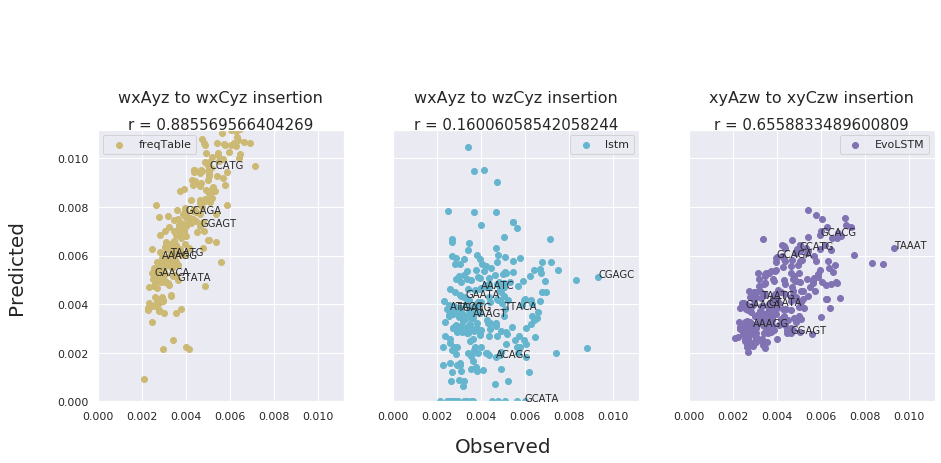

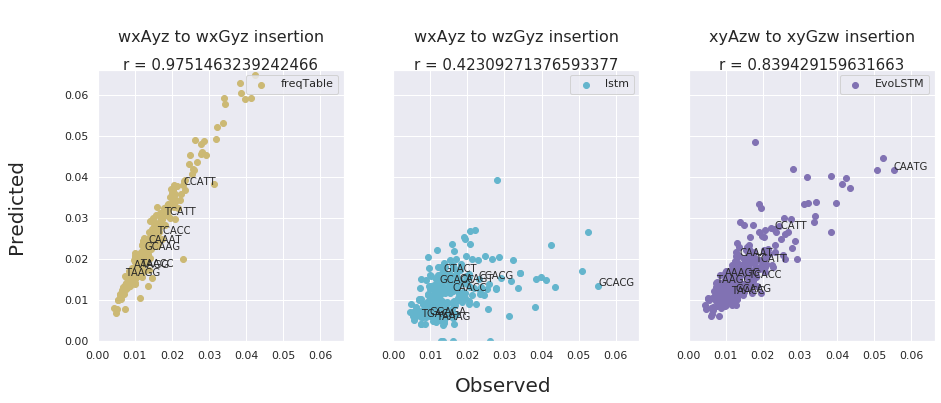

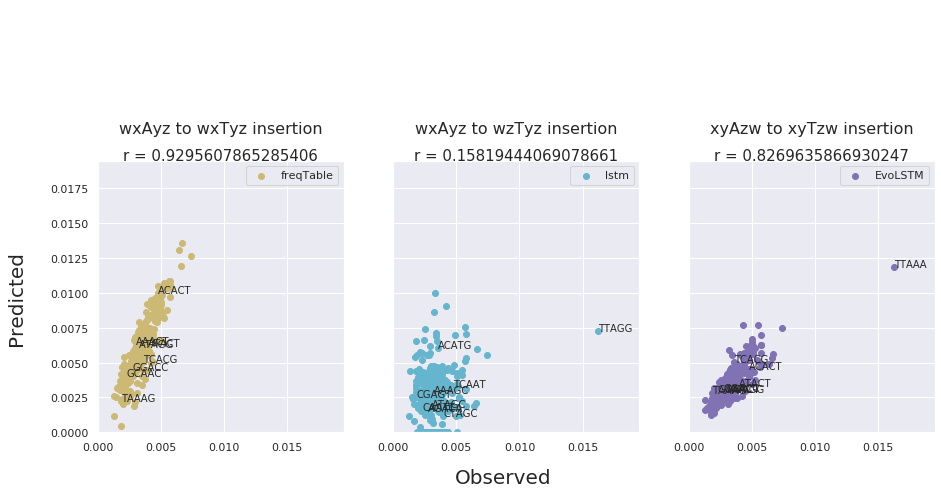

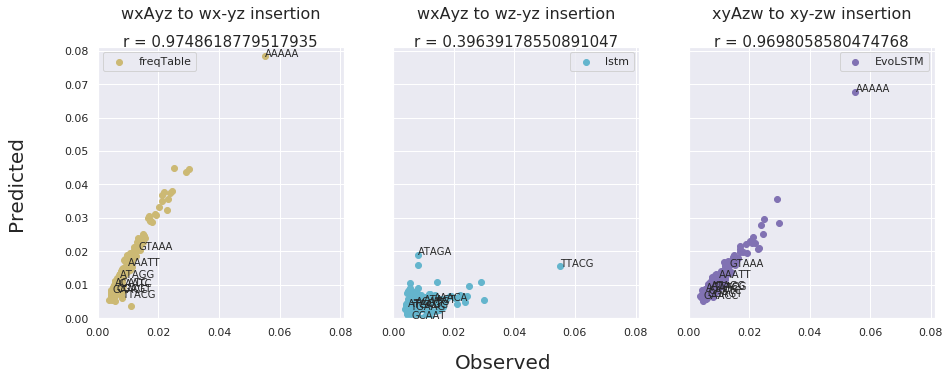

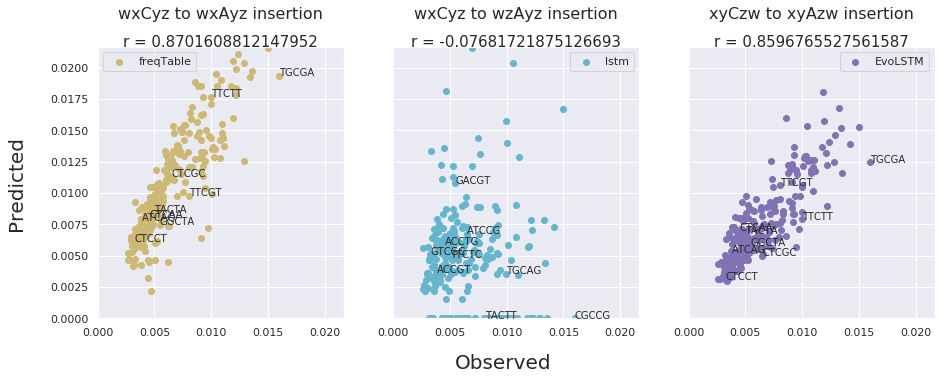

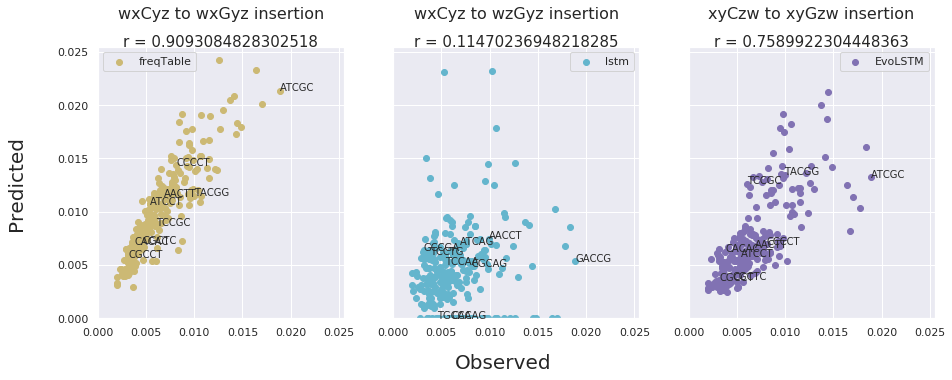

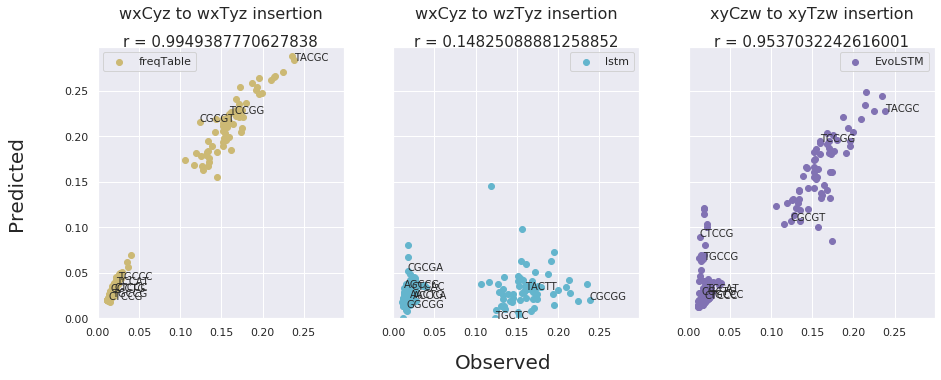

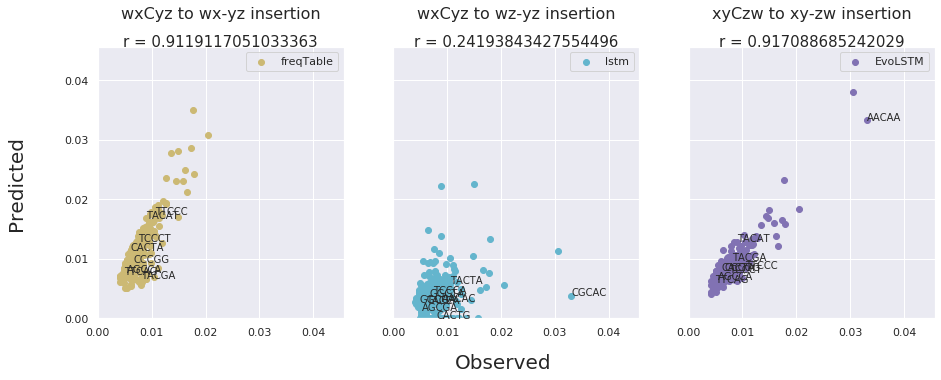

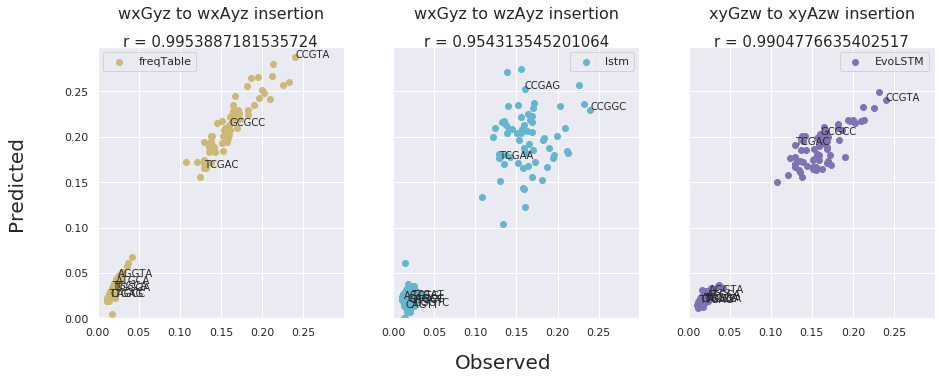

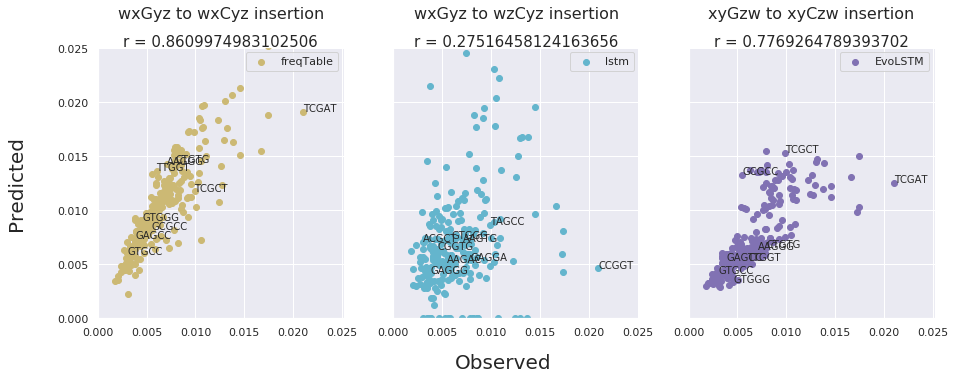

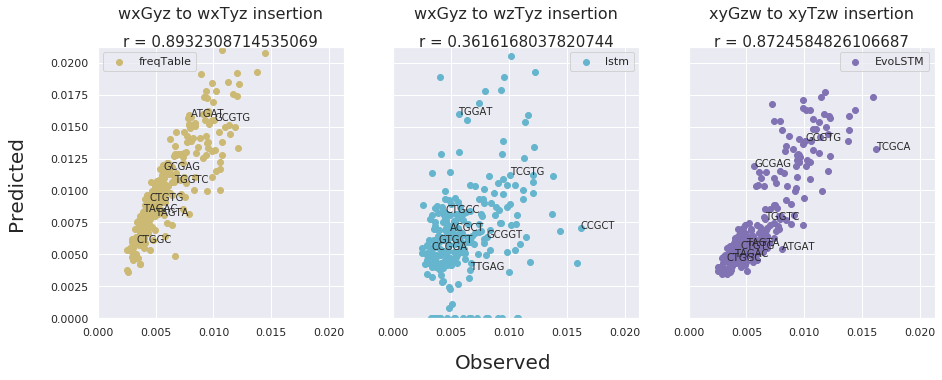

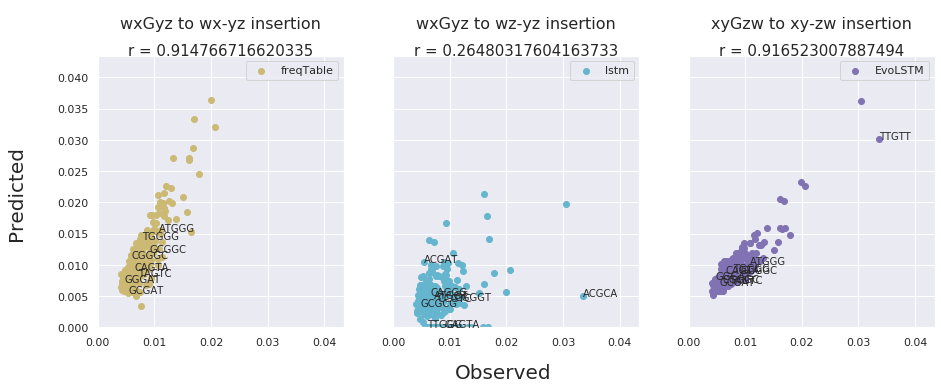

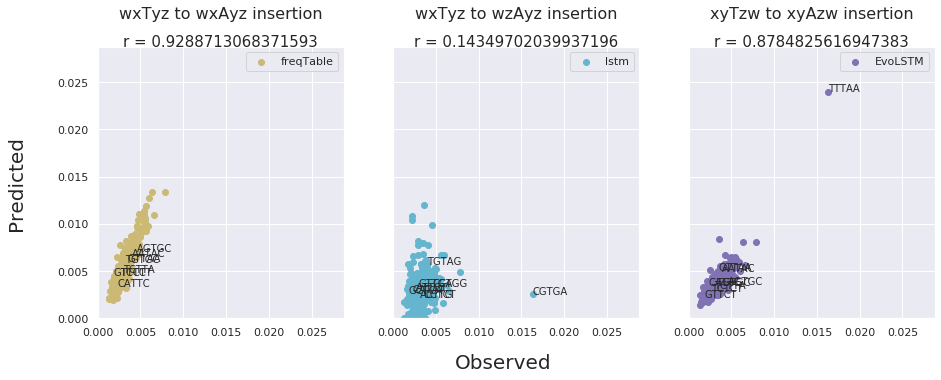

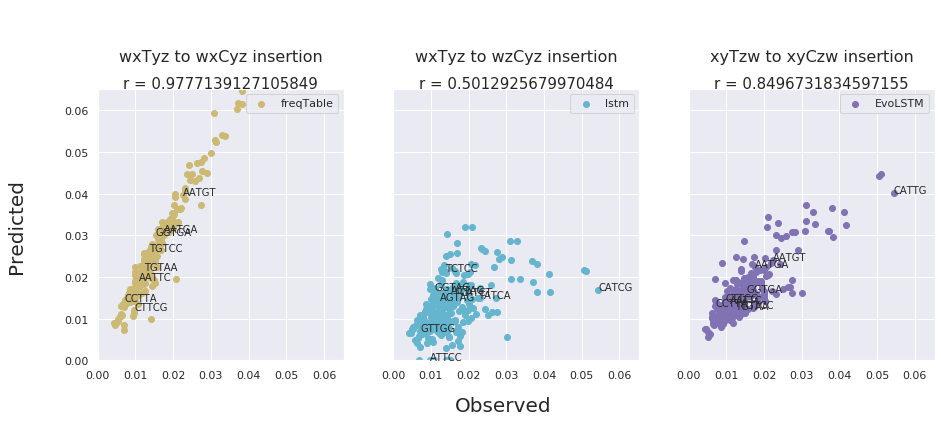

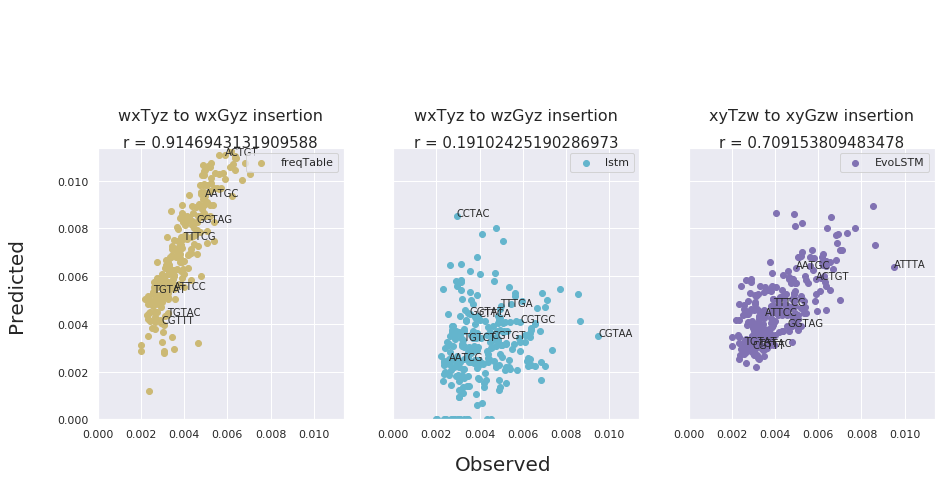

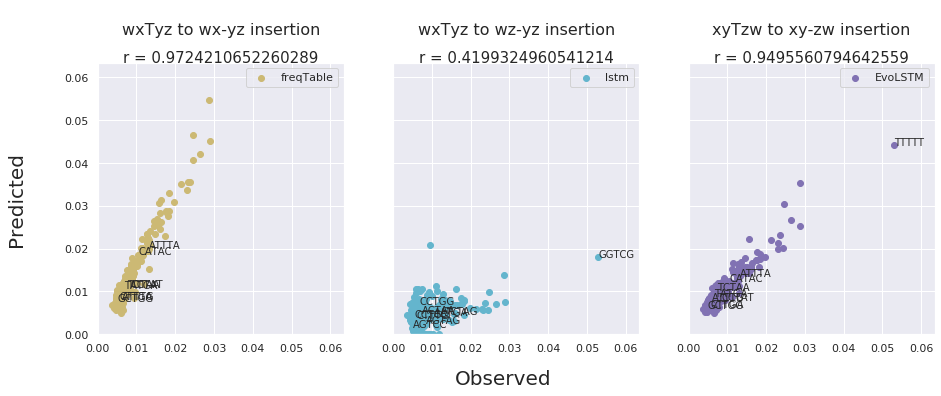

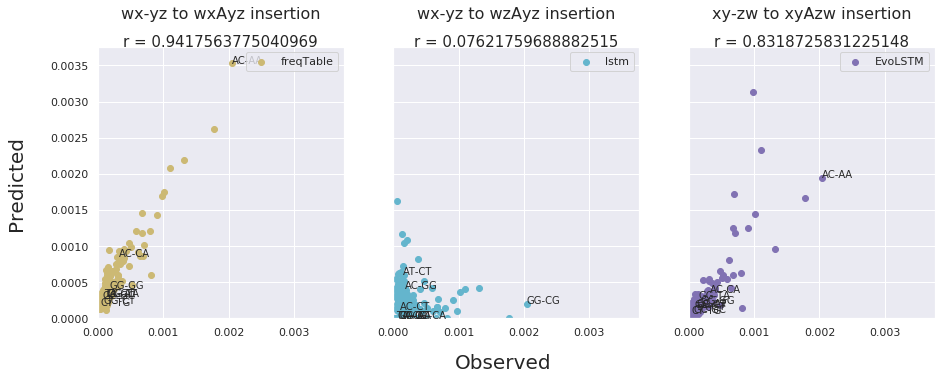

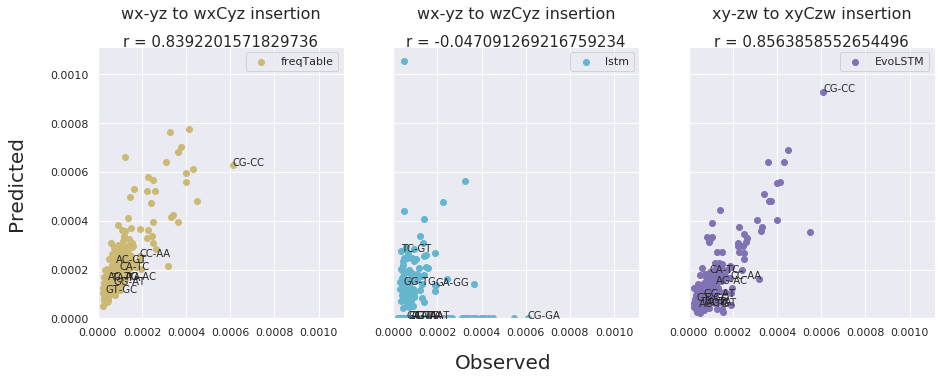

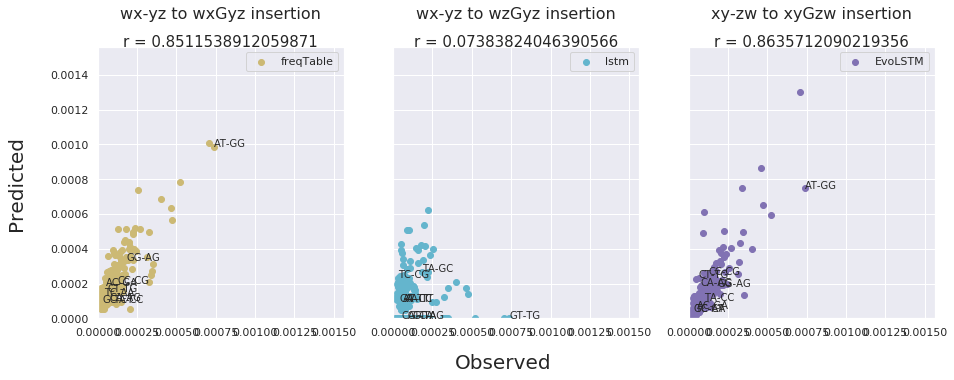

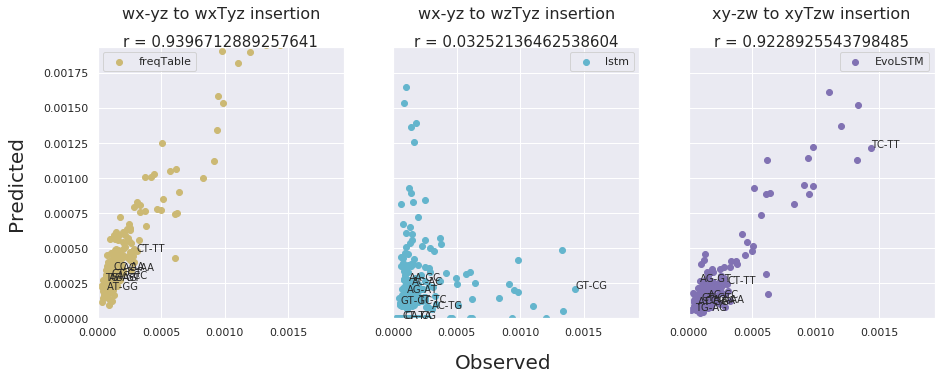

/home/mcb/users/dlim63/miniconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


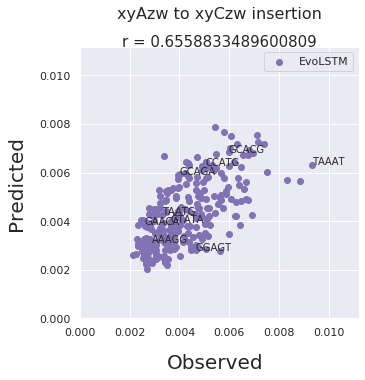

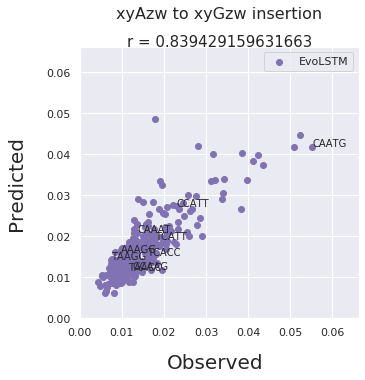

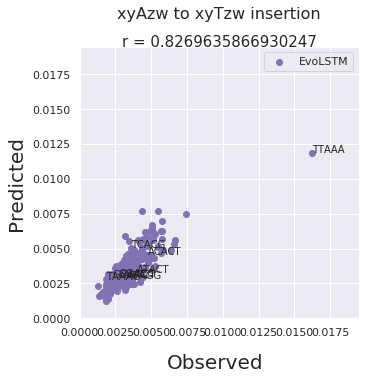

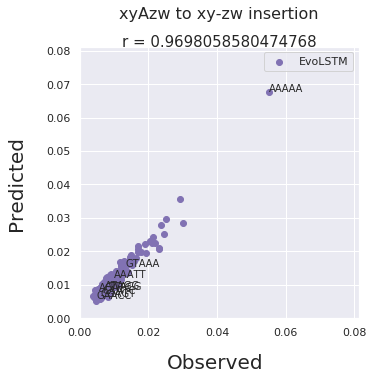

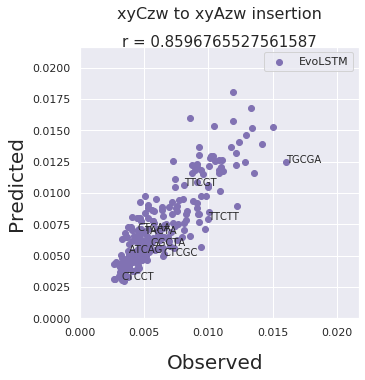

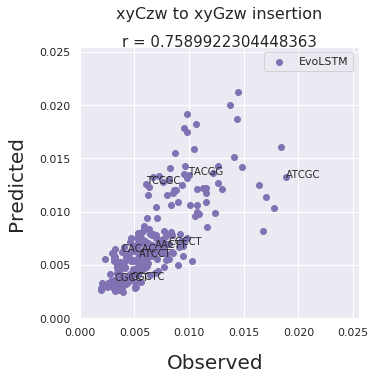

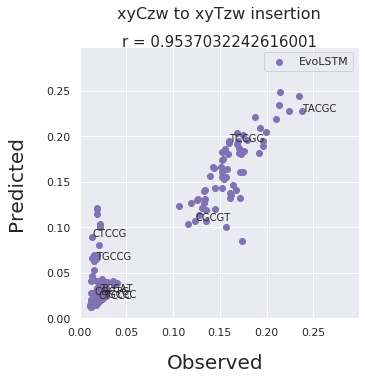

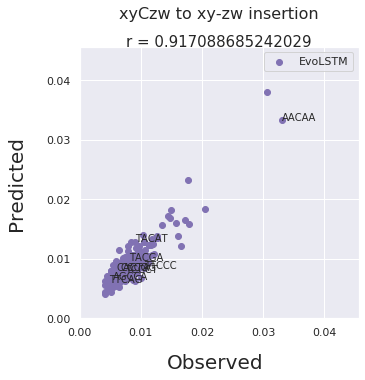

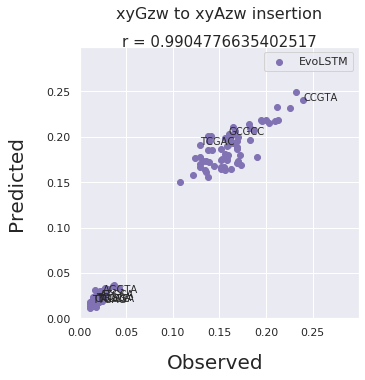

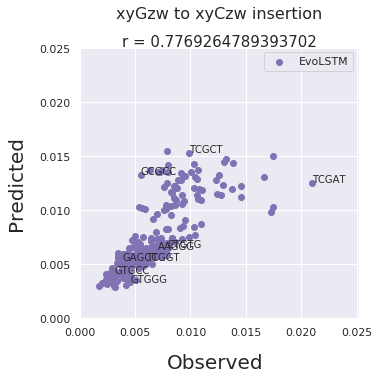

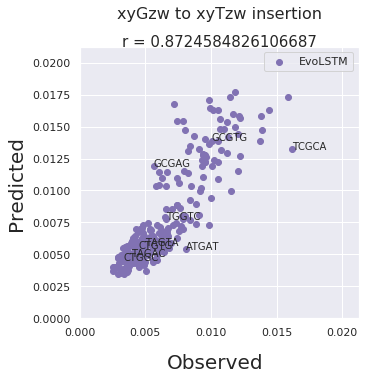

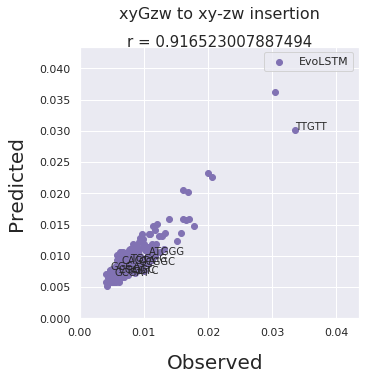

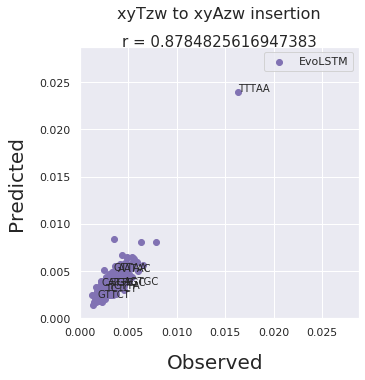

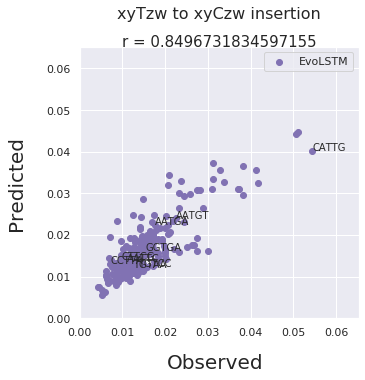

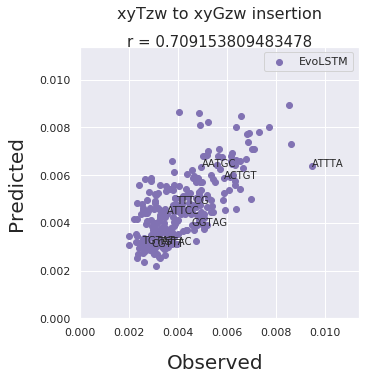

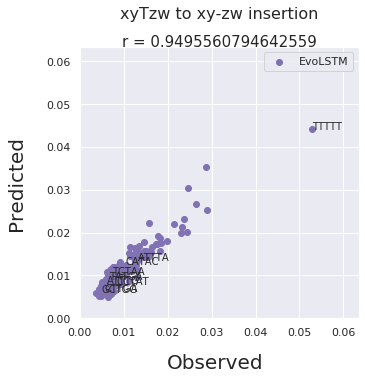

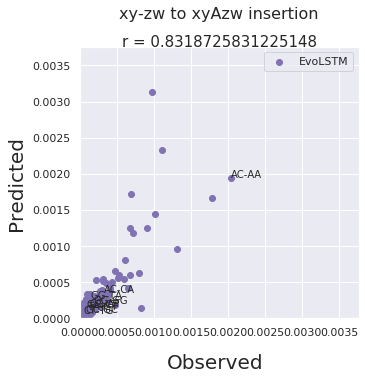

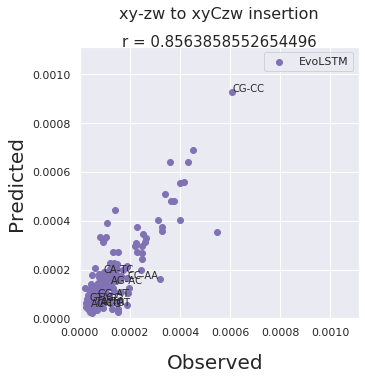

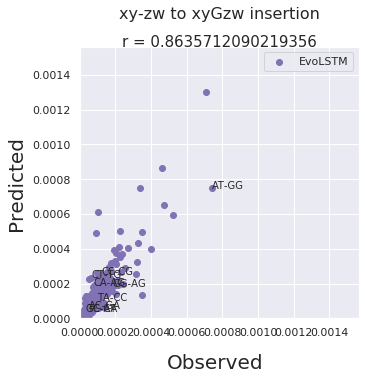

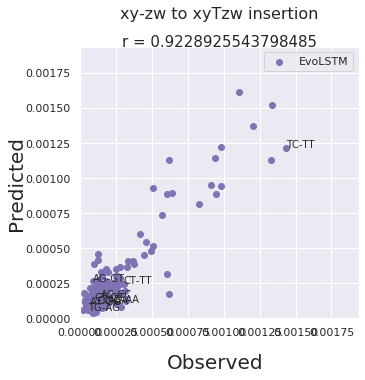


A $rightarrow$ C & 0.656 & 0.160 & 0.886
A $rightarrow$ G & 0.839 & 0.423 & 0.975
A $rightarrow$ T & 0.827 & 0.158 & 0.930
A $rightarrow$ - & 0.970 & 0.396 & 0.975
C $rightarrow$ A & 0.860 & -0.077 & 0.870
C $rightarrow$ G & 0.759 & 0.115 & 0.909
C $rightarrow$ T & 0.954 & 0.148 & 0.995
C $rightarrow$ - & 0.917 & 0.242 & 0.912
G $rightarrow$ A & 0.990 & 0.954 & 0.995
G $rightarrow$ C & 0.777 & 0.275 & 0.861
G $rightarrow$ T & 0.872 & 0.362 & 0.893
G $rightarrow$ - & 0.917 & 0.265 & 0.915
T $rightarrow$ A & 0.878 & 0.143 & 0.929
T $rightarrow$ C & 0.850 & 0.501 & 0.978
T $rightarrow$ G & 0.709 & 0.191 & 0.915
T $rightarrow$ - & 0.950 & 0.420 & 0.972
- $rightarrow$ A & 0.832 & 0.076 & 0.942
- $rightarrow$ C & 0.856 & -0.047 & 0.839
- $rightarrow$ G & 0.864 & 0.074 & 0.851
- $rightarrow$ T & 0.923 & 0.033 & 0.940
A $rightarrow$ C & 0.656 & 0.160 & 0.886
A $rightarrow$ G & 0.839 & 0.423 & 0.975
A $rightarrow$ T & 0.827 & 0.158 & 0.930
A $rightarrow$ - & 0.970 & 0.396 & 0.975
C $rightarrow

In [22]:
plotCombine(2, 15)

In [122]:
import collections
k = 2
def analyzeMut(ancNuc, desNuc):
    predSeq = np.load('data/pred_context{}->{}_{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,15,k*2+1), allow_pickle = True).item()

    tableSeq = np.load('data/predTable_context{}->{}_{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,15,k*2+1), allow_pickle = True).item()
    
    trueSeq = np.load('data/true_context{}->{}_{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,15,k*2+1), allow_pickle = True).item()

#     evolSeq = np.load('data/true_evol_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()
    
    lstmSeq = np.load('data/pred_lstm_context{}->{}_{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,15,k*2+1), allow_pickle = True).item()
    
    return predSeq, tableSeq , trueSeq, lstmSeq

ancNuc = [ '-']
desNuc = ['A', 'C', 'G', 'T', '-']    

# for i in ancNuc:
#     for j in desNuc:
#         if i != j :
#             print('=========================================================================================================')
#             pred, table, true, lstm = analyzeMut(i,j)
#             pred = collections.OrderedDict(sorted(pred.items()))
#             table = collections.OrderedDict(sorted(table.items()))
#             lstm = collections.OrderedDict(sorted(lstm.items()))
#             true = collections.OrderedDict(sorted(true.items()))
#             print('Context of {} -> {}'.format(i,j))
#             for a, b, c, d, e, f, g,h in zip(pred.keys(), pred.values(), table.keys(), table.values(), lstm.keys(), lstm.values(), true.keys(), true.values()):
#                 print("")
#                 print("{}->{} |".format(i,j),'EvoLSTM :', a,'{:,.5f}'.format(b), '|' ,'Table :', c, '{:,.5f}'.format(d), '|', 'lstm :' ,e,'{:,.5f}'.format(f), '|', 'Observed :' ,g,'{:,.5f}'.format(h),  '\\', "\\" )
#             print('=========================================================================================================')
#             print()
#             print()
 
count = 0
pred, table, true, lstm = analyzeMut('A','G')
for a, b, c, d, e, f in zip(pred.keys(), pred.values(), table.keys(), table.values(), true.keys(), true.values()):
    if count<10 or count>= (len(pred.keys())-10):
        print( a,':','{:,.5f}'.format(b), '&' , c,':', '{:,.5f}'.format(d), '&' ,e,':','{:,.5f}'.format(f), '\\', "\\" )
    count+= 1
# for a, b, c, d, e, f in zip(pred.keys(), pred.values(), table.keys(), table.values(), true.keys(), true.values()):
#     print('EvoLSTM: ', a,b, 'Table:', c, d, | 'Observed: ',e,f )



CCACG : 0.04859 & CAATG : 0.07956 & CAATG : 0.05525 \ \
CTATG : 0.04466 & CTATG : 0.07796 & CTATG : 0.05242 \ \
GCACG : 0.04213 & CTATA : 0.07548 & CTATA : 0.05086 \ \
CAATG : 0.04189 & CAATC : 0.07018 & CAATC : 0.04355 \ \
CTATA : 0.04174 & CTATC : 0.06498 & CTATC : 0.04241 \ \
CTATT : 0.04036 & GTATA : 0.06290 & CAATT : 0.04121 \ \
CCATG : 0.03996 & CTATT : 0.06056 & CAATA : 0.03976 \ \
CTATC : 0.03981 & CAATT : 0.05936 & CTATT : 0.03847 \ \
CAATT : 0.03841 & CCATA : 0.05930 & GTATA : 0.03828 \ \
CAATC : 0.03739 & CAATA : 0.05901 & GCATG : 0.03426 \ \
AGAAG : 0.00865 & TAAAA : 0.01128 & TGAAC : 0.00650 \ \
TTAAA : 0.00850 & TGAAG : 0.01115 & TGAAG : 0.00622 \ \
TGAAT : 0.00845 & CGAGT : 0.01050 & GAAAC : 0.00620 \ \
TAAAG : 0.00823 & GAAAC : 0.01041 & TAAAA : 0.00606 \ \
GAAAA : 0.00820 & GAAAT : 0.01004 & TAAAG : 0.00605 \ \
TAAAC : 0.00799 & AAAAC : 0.01000 & GAAAT : 0.00557 \ \
TGAAC : 0.00754 & TAAAT : 0.00813 & AAAAC : 0.00534 \ \
TGAAG : 0.00661 & CGAAC : 0.00790 & AAAAT : 0.00

In [86]:
def occurence(inputAll, size):
    freqDict = {}
    for i in tqdm(range(len(inputAll)-size)):
        try:
            freqDict[inputAll[i:i+size]] +=1
        except KeyError:
            freqDict[inputAll[i:i+size]] = 1
    return freqDict
freq3 = occurence(inputAll[0], 3)
freq5 = occurence(inputAll[0], 5)
freq7 = occurence(inputAll[0], 7)



 35%|███▍      | 51837306/149860429 [00:24<00:50, 1958202.97it/s]


 69%|██████▉   | 103248035/149860429 [00:48<00:21, 2142759.36it/s]


100%|██████████| 149860429/149860429 [01:10<00:00, 2120955.39it/s]

  3%|▎         | 3773793/149860427 [00:01<01:09, 2106858.85it/s]


 37%|███▋      | 55685667/149860427 [00:26<00:44, 2106685.55it/s]


 72%|███████▏  | 108361993/149860427 [00:50<00:19, 2144244.19it/s]


100%|██████████| 149860427/149860427 [01:09<00:00, 2162854.24it/s]

  7%|▋         | 10856959/149860425 [00:05<01:05, 2119579.55it/s]


 41%|████      | 60907789/149860425 [00:29<00:40, 2172557.38it/s]


 73%|███████▎  | 109956768/149860425 [00:53<00:18, 2119585.61it/s]


100%|██████████| 149860425/149860425 [01:13<00:00, 2050702.50it/s]


In [89]:
print(freq3)

{'CCG': 728210, 'CGG': 726429, 'GGA': 2550758, 'GAG': 2893128, 'AGC': 2300581, 'GCA': 2269539, 'CAT': 2500962, 'ATA': 2497425, 'TAT': 2503577, 'ATG': 2497168, 'TGC': 2273865, 'GCT': 2304736, 'CTG': 3356466, 'TGT': 2820829, 'GTT': 2013317, 'TTT': 5204804, 'TTG': 2639404, 'TGG': 3055040, 'GGT': 1900776, 'GTA': 1499264, 'ATT': 3206602, 'GTG': 2461777, 'GGC': 2333847, 'GCC': 2334488, 'CCT': 3012575, 'ATC': 1889473, 'TCT': 3183818, 'CTT': 2786153, 'TTC': 2718269, 'CTC': 2896317, 'TCA': 2811103, 'CAG': 3352959, 'AGT': 2266668, 'TAG': 1726876, 'AGG': 3003912, 'TCC': 2552952, 'CTA': 1722224, 'TAA': 2640162, 'AAA': 5164646, 'AAT': 3194031, 'GGG': 2607380, 'GAT': 1892098, 'TTA': 2648399, 'AAG': 2773899, 'AAC': 2001115, 'ACT': 2260031, 'CCA': 3046648, 'TGA': 2805081, 'GAA': 2706350, 'TAC': 1496697, 'CCC': 2602837, 'CAC': 2455582, 'ACC': 1899992, 'CAA': 2622533, 'GTC': 1516675, 'ACA': 2804747, 'AGA': 3175701, 'GAC': 1512397, 'ACG': 501021, 'CGT': 502760, 'CGA': 472433, 'TCG': 472861, 'CGC': 644266

In [ ]:
plotCombine(3, 1)

In [ ]:
plotCombine(3, 5)

In [ ]:
plotCombine(3, 15)

In [ ]:
plotCombine(4, 5)

In [ ]:
plotCombine(4, 15)

In [ ]:
plotCombine(5, 5)

In [ ]:
plotCombine(5, 15)

In [60]:
daum = np.load('data/pred_contextA->C__HPGPNRMPC_15_3.npy'.format(ancNuc,desNuc,ancName,15,3), allow_pickle = True).item()
print(daum)

{'CAC': 0.006463233563367055, 'CAT': 0.006184420235093536, 'CAG': 0.005690496066310384, 'CAA': 0.0054043171239408615, 'AAA': 0.004927540048243384, 'TAC': 0.00477518161658639, 'AAC': 0.004279114393725498, 'TAA': 0.004265268570640741, 'TAT': 0.004183614084967229, 'AAT': 0.004091381705437424, 'AAG': 0.0038844240543725638, 'TAG': 0.003396306393742226, 'GAC': 0.0031744310521642136, 'GAT': 0.0031198172610509604, 'GAG': 0.002669774721339671, 'GAA': 0.0024073013468324496}


In [42]:
contextLength = 1
numBin = 16
def contextMut(size, ancNuc, desNuc, anc, des, pred, evol, lstm = False):
    cont = list(itertools.product('ACGT', repeat=size))
    cont1 = list(itertools.product('ACGT', repeat=size))
    context_dict = {}
    count_dict = {}
    for i in cont1:
        for j in cont1:
            #context_dict[(''.join(i)+'A'+''.join(j) , ''.join(i)+'G'+''.join(j))] = 0
            context_dict[(''.join(i)+ancNuc+''.join(j))] = 0
            count_dict[(''.join(i)+ancNuc+''.join(j))] = 0
    for a,b in zip(anc, des):
        for i in range(len(a)-size*2-len(ancNuc)):
            if a[i+size:i+size+len(ancNuc)] == ancNuc :
                count_dict[(a[i:i+size*2+len(ancNuc)])] += 1
    for a,b in tqdm_notebook(zip(anc, des)):
        for i in range(len(a)-size*2-len(ancNuc)):
            if a[i+size:i+size+len(ancNuc)] == ancNuc and b[i+size+int(len(ancNuc)/2)] == desNuc:
                context_dict[(a[i:i+size*2+len(ancNuc)])] += 1
    for key in context_dict.keys():
        if count_dict[key] !=0:
            context_dict[key] = context_dict[key]/count_dict[key] 
        else :
            continue
    sorted_context = sorted(context_dict.items(), key=operator.itemgetter(1), reverse = 1)
    sorted_context = dict(sorted_context)
    if lstm ==False:
        if pred == True and evol ==False:
            np.save('data/pred_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
        elif pred == True and evol == True:
            np.save('data/pred_evol_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
        elif pred == False and evol ==False:
            np.save('data/true_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
        elif pred == False and evol ==True:
            np.save('data/true_evol_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
        return sorted_context
    elif lstm ==True :
        if pred == True:
            np.save('data/pred_lstm_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
        elif pred ==False:
            np.save('data/true_lstm_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
    return sorted_context
            
def contextMutInsert(size, ancNuc, desNuc, anc, des, pred, evol, lstm = False):
    cont1 = list(itertools.product('ACGT', repeat=size-1))
    cont = list(itertools.product('ACGT', repeat=size))
    context_dict = {}
    count_dict = {}
    for i in cont:
        for j in cont:
            #context_dict[(''.join(i)+'A'+''.join(j) , ''.join(i)+'G'+''.join(j))] = 0
            context_dict[(''.join(i)+ancNuc+''.join(j))] = 0
            count_dict[(''.join(i)+ancNuc+''.join(j))] = 0
    for a,b in zip(anc, des):
        for i in range(len(a)-size*2-len(ancNuc)):
            count_dict[(a[i:i+size]+ancNuc+a[i+size+len(ancNuc):i+size*2+len(ancNuc)])] += 1
    for a,b in zip(anc, des):
        for i in range(len(a)-size*2-len(ancNuc)):
            inserted_nuc = inv_dict[b[i+size+int(len(ancNuc)/2)-1]]
            if len(inserted_nuc) >1 and inserted_nuc[1] == desNuc:
                context_dict[(a[i:i+size]+ancNuc+a[i+size+len(ancNuc):i+size*2+len(ancNuc)])] += 1
    for key in context_dict.keys():
        if count_dict[key] !=0:
            context_dict[key] = context_dict[key]/count_dict[key] 
        else :
            continue
    sorted_context = sorted(context_dict.items(), key=operator.itemgetter(1), reverse = 1)
    sorted_context = dict(sorted_context)
    if lstm ==False:
        if pred == True and evol ==False:
            np.save('data/pred_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
        elif pred == True and evol == True:
            np.save('data/pred_evol_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
        elif pred == False and evol ==False:
            np.save('data/true_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
        elif pred == False and evol ==True:
            np.save('data/true_evol_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
        return sorted_context
    elif lstm ==True :
        if pred == True:
            np.save('data/pred_lstm_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
        elif pred ==False:
            np.save('data/true_lstm_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
    return sorted_context
            
def calculateR(contextLen, ancCase, desCase):
    sorted_context = contextMut(contextLen, ancCase, desCase, inputAll, predAll, pred = True, evol = False)
    contextMut(contextLen, ancCase, desCase, inputAll, outputAll, pred = False, evol = False)
    contextMut(contextLen, ancCase, desCase, lstm_inputAll, lstm_predAll, pred = True, evol = False, lstm = True)

    sorted_word = list(sorted_context.keys())
    top = sorted_word[0]
    mid = sorted_word[int(len(sorted_word)/2)]
    bot = sorted_word[-1]
    return top, mid, bot

def calculateRInsert(contextLen, ancCase, desCase):
    sorted_context = contextMutInsert(contextLen, ancCase, desCase, inputAll, predAll, pred = True, evol = False)
    contextMutInsert(contextLen, ancCase, desCase, inputAll, outputAll, pred = False, evol = False)
    contextMutInsert(contextLen, ancCase, desCase, lstm_inputAll, lstm_predAll, pred = True, evol = False, lstm = True)

    sorted_word = list(sorted_context.keys())
    top = sorted_word[0]
    mid = sorted_word[int(len(sorted_word)/2)]
    bot = sorted_word[-1]
    return top, mid, bot
    
def plotContextChange(contLen, ancCase, desCase, insert = False):
#     contextLen = contLen
#     if insert == True:
#         top, mid, bot = calculateRInsert(contextLen, ancCase, desCase)
        
#         tt, tm, tb = calculateRInsert(contextLen, top, desCase)
#         mt, mm, mb = calculateRInsert(contextLen, mid, desCase)
#         bt, bm, bb = calculateRInsert(contextLen, bot, desCase)

#         ttt, ttm, ttb = calculateRInsert(contextLen, tt, desCase)
#         mmt, mmm, mmb = calculateRInsert(contextLen, mm, desCase)
#         bbt, bbm, bbb = calculateRInsert(contextLen, bb, desCase)
#     else :
#         top, mid, bot = calculateR(contextLen, ancCase, desCase)
#         tt, tm, tb = calculateR(contextLen, top, desCase)
#         mt, mm, mb = calculateR(contextLen, mid, desCase)
#         bt, bm, bb = calculateR(contextLen, bot, desCase)

#         ttt, ttm, ttb = calculateR(contextLen, tt, desCase)
#         mmt, mmm, mmb = calculateR(contextLen, mm, desCase)
#         bbt, bbm, bbb = calculateR(contextLen, bb, desCase)
    
    
#     topList = [ancCase, top, tt]
#     midList = [ancCase, mid, mm]
#     botList = [ancCase, bot, bb]
#     ancWords = [topList, midList, botList]
    

#     print(topList)
#     print(midList)
#     print(botList)
#     print(ancWords)
#     topList=['C', 'ACG', 'GACGG']
#     midList=['C', 'CCT', 'ACCTT']
#     botList=['C', 'TCA', 'TTCAA']
#     ancWords =[['C', 'ACG', 'GACGG'], ['C', 'CCT', 'ACCTT'], ['C', 'TCA', 'TTCAA']]

    topList=['A', 'AAA', 'AAAAA']
    midList=['A', 'CAC', 'GCACC']
    botList=['A', 'CAG', 'CCAGC']
    ancWords = [['A', 'AAA', 'AAAAA'], ['A', 'CAC', 'GCACC'], ['A', 'CAG', 'CCAGC']]
    
    f, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20,20))
    axs = axs.flatten()
    f.text(0.5, 0.08, 'Observed', ha='center', va='center', fontsize=40)
    f.text(0.05, 0.5, 'Predicted', ha='center', va='center', rotation='vertical', fontsize=40)
#     f.suptitle('Effect of adding flanking base contexts to {}->{} mutation'.format(ancCase, desCase), fontsize =30)

    index = 0
    for words in tqdm(ancWords):
        for j in desCase:
            for n, i in enumerate(words):
                if i != j:
                    predSeq = np.load('data/pred_context{}->{}_{}.npy'.format(i,j,ancName), allow_pickle = True).item()
                    trueSeq = np.load('data/true_context{}->{}_{}.npy'.format(i,j,ancName), allow_pickle = True).item()
                    true = list(trueSeq.values())
                    true_context = list(trueSeq.keys())
                    pred = []
                    for x in true_context:
                        pred.append(predSeq[x])
                    axs[index].scatter(true, pred, color = 'm')
#                     axs[index].axis('scaled')
#                     axs[index].axis('square')
                    axs[index].set_xlim([0, 1.1 * max(max(pred), max(true))])
                    axs[index].set_ylim([0, 1.1 * max(max(pred), max(true))])
                    axs[index].text(0.5,0.0, "r = {}".format(stats.pearsonr(pred, true)[0]), size=20, ha="center", 
                             transform=axs[index].transAxes)
                    axs[index].set_title('x{}y to {}'.format(i, j), fontsize=25)
                    for i, txt in enumerate(list(predSeq.keys())):
                        if i %10 ==0 or i%(int(len(true)/2))==0 or i%(int(len(true)-1))==0:
                            axs[index].annotate(txt, (true[i], pred[i]))

                    index += 1
                    f.savefig('figures/scatter_conChange_{}_{}_{}->{}.png'.format(ancName, desName,  ancCase, desCase))
#                     print('pearson corr: ', stats.pearsonr(pred, true)[0])
    plt.show()
    plt.close()
#                     plotPointMut(numBin,i, j)
#                     plotScatter(numBin,i, j)
#     analyzeMut(ancCase[0],desCase[0])

100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


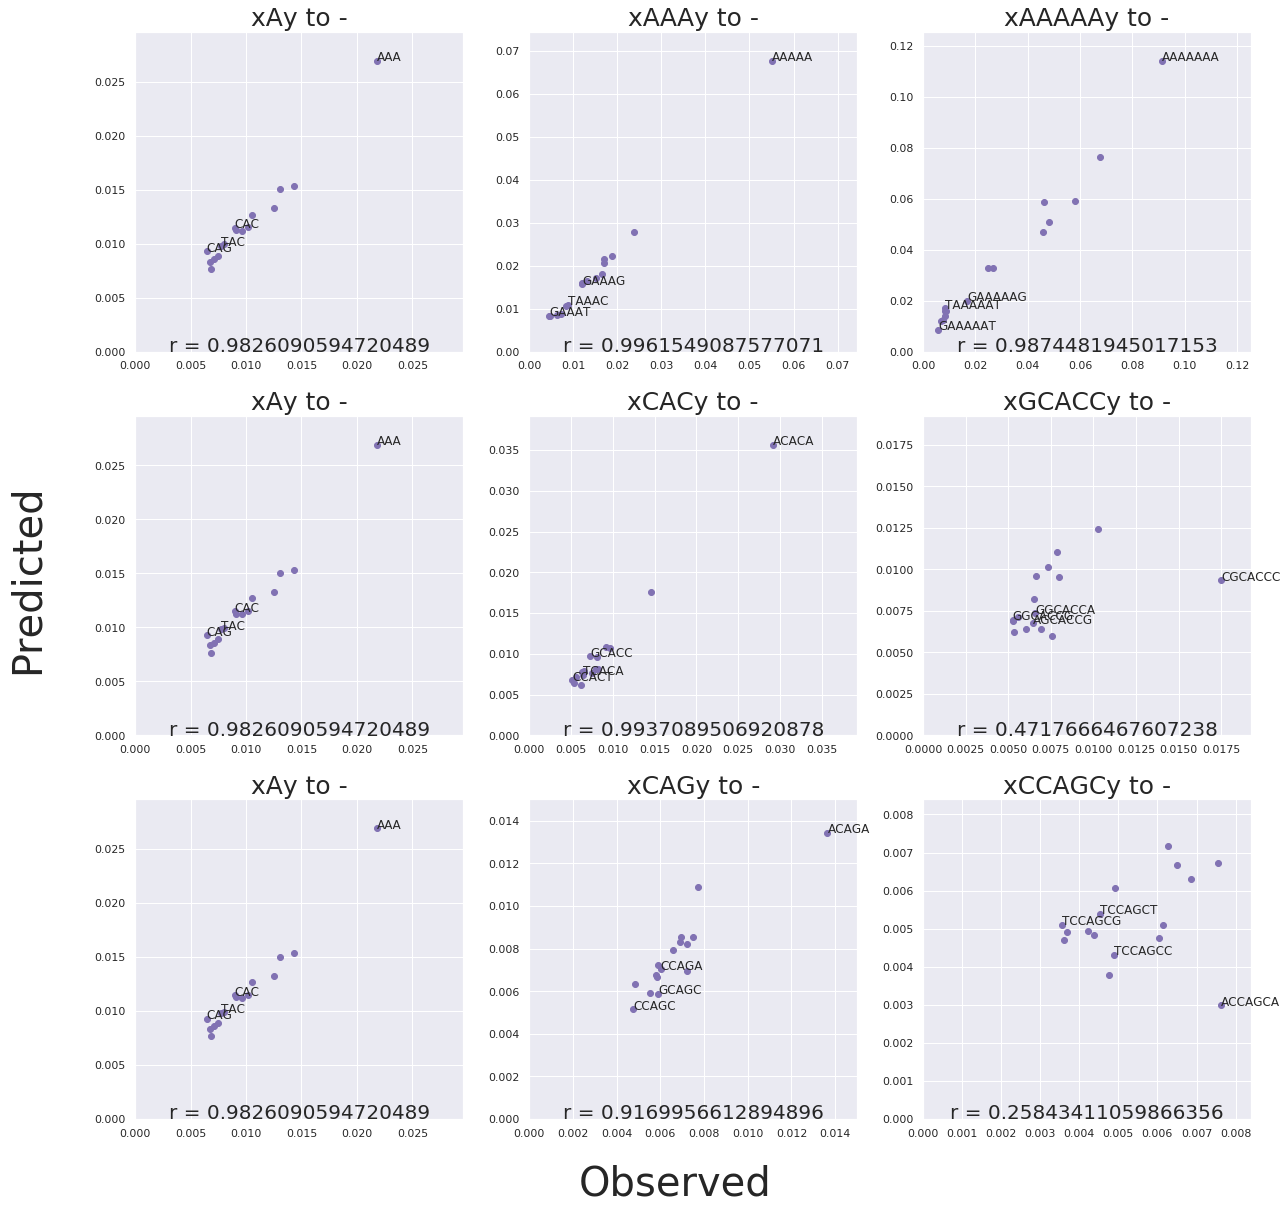

In [43]:
plotContextChange(1, 'A', '-', insert = False)

100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


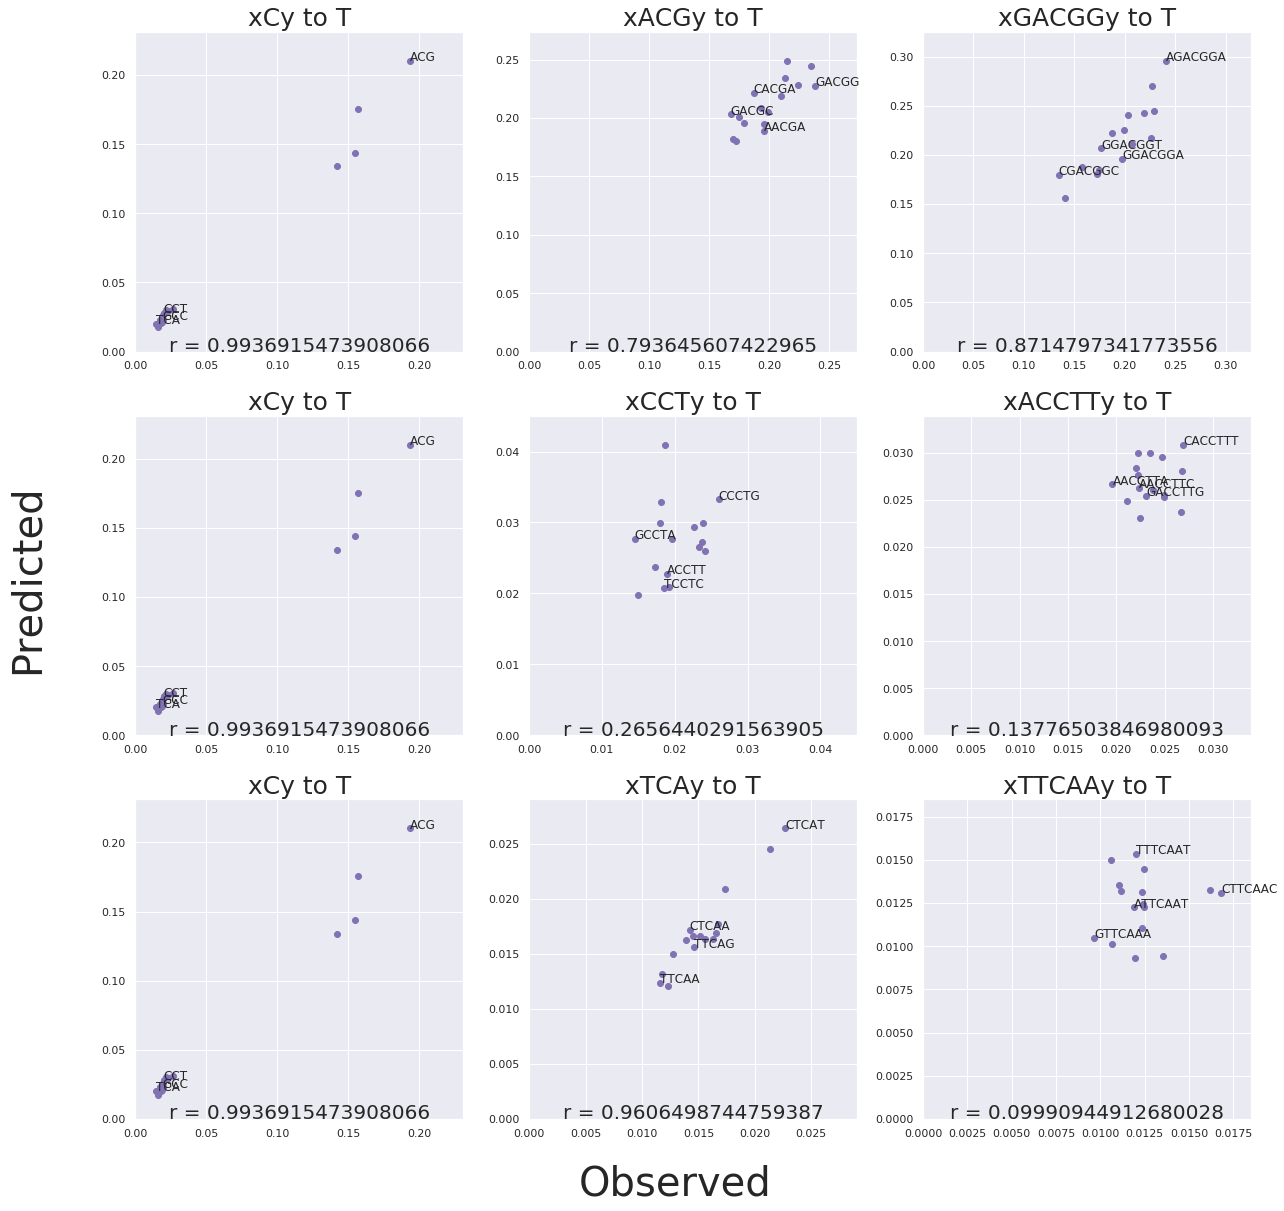

In [36]:
# plotContextChange(1, 'A', 'G', insert = False)
plotContextChange(1, 'C', 'T', insert = False)
# plotContextChange(1, 'A', '-', insert = False)
# plotContextChange(1, '-', 'T', insert = True)

In [ ]:
analyzeMut('TAG','G')
contextMut(contextLen, 'TAG', 'G', inputAll, predAll, pred = True, evol = False)